In [55]:
#imports 
import pandas as pd
import numpy
import math
import csv
import random
from sklearn import cross_validation, linear_model, model_selection
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [56]:
#load in the data
folder = '../input'
season_data = pd.read_csv('RegularSeasonDetailedResultserror.csv')
tourney_data = pd.read_csv('NCAATourneyDetailedResults.csv')
seeds = pd.read_csv('NCAATourneySeeds.csv')
team_names = pd.read_csv('Teams.csv', index_col=0)
team_names_olivia = pd.read_csv('Teams.csv', index_col=0)
teams_copy = pd.read_csv('Teams.csv')
frames = [season_data, tourney_data]
all_data = pd.concat(frames)
#all_data = pd.read_csv('NCAATourneyDetailedResults.csv')
stat_fields = ['score', 'fga', 'fgp', 'fga3', '3pp', 'ftp', 'or', 'ormargin', 'dr',
                   'ast', 'to', 'tomargin', 'stl', 'blk', 'pf']
prediction_year = 2017
base_elo = 1600
team_elos = {}
team_stats = {}
X = []
y = []
submission_data = []
def initialize_data():
    for i in range(1985, prediction_year+1):
        team_elos[i] = {}
        team_stats[i] = {}
initialize_data()

#print(all_data)

#print(seeds)
season_data.head(10)
#teams_copy.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
5,2003,11,1458,81,1186,55,H,0,26,57,...,11,12,17,6,22,8,19,4,3,25
6,2003,12,1161,80,1236,62,H,0,23,55,...,15,20,28,9,21,11,30,10,4,28
7,2003,12,1186,75,1457,61,N,0,28,62,...,17,17,23,8,25,10,15,14,8,18
8,2003,12,1194,71,1156,66,N,0,28,58,...,18,12,27,13,26,13,25,8,2,18
9,2003,12,1458,84,1296,56,H,0,32,67,...,14,7,12,9,23,10,18,1,3,18


In [57]:
teams_won_most_times = team_names.join(pd.DataFrame(tourney_data['WTeamID'].value_counts()[:]), how='right')
print(teams_won_most_times)

#teamid = 1242 # KANSAS example to test
#teamname = teams_copy.loc[teams_copy['TeamID'] == teamid]['TeamName'].tolist()[0]
#teamwins = teams_won_most_times.loc[teams_won_most_times['Team_Name'] == teamname]['Tourney Wins'].tolist()[0]
#print(teamwins)

             TeamName  FirstD1Season  LastD1Season  WTeamID
1314   North Carolina           1985          2018       42
1242           Kansas           1985          2018       38
1246         Kentucky           1985          2018       35
1181             Duke           1985          2018       33
1277      Michigan St           1985          2018       31
1196          Florida           1985          2018       30
1163      Connecticut           1985          2018       29
1458        Wisconsin           1985          2018       28
1257       Louisville           1985          2018       28
1393         Syracuse           1985          2018       25
1112          Arizona           1985          2018       22
1211          Gonzaga           1985          2018       22
1437        Villanova           1985          2018       21
1417             UCLA           1985          2018       21
1462           Xavier           1985          2018       20
1139           Butler           1985    

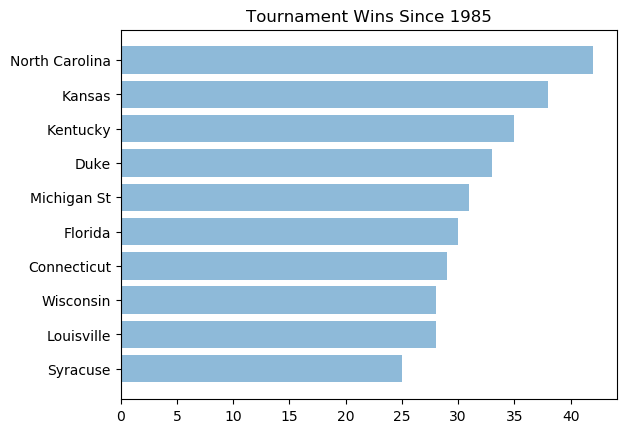

In [58]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
tourney_wins_vis = team_names_olivia.join(pd.DataFrame(tourney_data['WTeamID'].value_counts()[:10]), how='right')
tourney_wins_vis.columns = ['Team_Name', 'First Win Year', 'Last Win Year', 'Tourney Wins']

tourney_names = (tourney_wins_vis['Team_Name'])
tourney_wins = (tourney_wins_vis['Tourney Wins'])
    
plt.barh(tourney_names, tourney_wins, align='center', alpha=0.5)
#plt.yticks(y_pos, objects)
#plt.xlabel('Number of Tournament Wins')
plt.title('Tournament Wins Since 1985')
plt.gca().invert_yaxis()

plt.savefig('TournamentWins.jpg')
plt.show()

In [59]:
#helper functions

def get_elo(season, team):
    try:
        return team_elos[season][team]
    except:
        try:
            # Get the previous season's ending value.
            team_elos[season][team] = team_elos[season-1][team]
            return team_elos[season][team]
        except:
            # Get the starter elo.
            team_elos[season][team] = base_elo
            return team_elos[season][team]
        
def calc_elo(win_team, lose_team, season):
    winner_rank = get_elo(season, win_team)
    loser_rank = get_elo(season, lose_team)
    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    new_loser_rank = loser_rank - new_rank_diff
    return new_winner_rank, new_loser_rank

#gets tourney wins for team
def get_tourneywins(teamid):
    try:
        teamname = teams_copy.loc[teams_copy['TeamID'] == teamid]['TeamName'].tolist()[0]
        tourneywins = teams_won_most_times.loc[teams_won_most_times['Team_Name'] == teamname]['Tourney Wins'].tolist()[0]
        return tourneywins
    except:
        return 0
    
    
#gets average stats over each season
def get_stat(season, team, field):
    try:
        l = team_stats[season][team][field]
        return sum(l) / float(len(l))
    except:
        return 0
    
def update_stats(season, team, fields):
    if team not in team_stats[season]:
        team_stats[season][team] = {}
    for key, value in fields.items():
        # Make sure we have the field.
        if key not in team_stats[season][team]:
            team_stats[season][team][key] = []
        if len(team_stats[season][team][key]) >= 9:
            team_stats[season][team][key].pop()
        team_stats[season][team][key].append(value)

def predict_winner(team_1, team_2, model, season, stat_fields):
    features = []
    # Team 1
    features.append(get_elo(season, team_1))
    features.append(get_tourneywins(team_1))
    for stat in stat_fields:
        features.append(get_stat(season, team_1, stat))
    # Team 2
    features.append(get_elo(season, team_2))
    features.append(get_tourneywins(team_2))
    for stat in stat_fields:
        features.append(get_stat(season, team_2, stat))
    return model.predict_proba([features])



## <p style="text-align: left;">Features:
wfgm = field goals made </p>

wfga = field goals attempted </p>

wfgm3 = three pointers made </p>

wfga3 = three pointers attempted </p>

wftm = free throws made </p>

wfta = free throws attempted </p>

wor = offensive rebounds</p>

wdr = defensive rebounds</p>

wast = assists</p>

wto = turnovers</p>

wstl = steals</p>

wblk = blocks</p>

wpf = personal fouls</p>


## <p style="text-align: left;">Extracted Features:
fgp = field goal percentage </p>

3pp = three point percentage </p>

ftw = free throw percentage </p>

elo = relative skill level of players </p>

tourney wins = the number of tournament wins that specific team has



In [60]:
#Main engine for building data

def build_season_data(all_data):
    # Calculate the elo for every game for every team, each season.
    # Store the elo per season so we can retrieve their end elo
    # later in order to predict the tournaments without having to
    # inject the prediction into this loop.
    for index, row in all_data.iterrows():
        
        # Used to skip matchups where we don't have usable stats yet.
        skip = 0
        # Get starter or previous elos.
        team_1_elo = get_elo(row['Season'], row['WTeamID'])
        team_2_elo = get_elo(row['Season'], row['LTeamID'])
        # Add 100 to the home team (# taken from Nate Silver analysis.)
        if row['WLoc'] == 'H':
            team_1_elo += 100
        elif row['WLoc'] == 'A':
            team_2_elo += 100         
        # We'll create some arrays to use later.
        team_1_features = [team_1_elo]
        team_2_features = [team_2_elo]
        # Factor in Tourney Performance
        team_1_tourneywins = get_tourneywins(row['WTeamID'])
        team_2_tourneywins = get_tourneywins(row['LTeamID'])
        
        team_1_features.append(team_1_tourneywins)
        team_2_features.append(team_2_tourneywins)
        
        # Build arrays out of the stats we're tracking..
        for field in stat_fields:
            team_1_stat = get_stat(row['Season'], row['WTeamID'], field)
            team_2_stat = get_stat(row['Season'], row['LTeamID'], field)
            if team_1_stat is not 0 and team_2_stat is not 0:
                team_1_features.append(team_1_stat)
                team_2_features.append(team_2_stat)
            else:
                skip = 1
        if skip == 0:  # Make sure we have stats.
            # Randomly select left and right and 0 or 1 so we can train
            # for multiple classes.
            if random.random() > 0.5:
                X.append(team_1_features + team_2_features)
                y.append(0)
            else:
                X.append(team_2_features + team_1_features)
                y.append(1)
        # AFTER we add the current stuff to the prediction, update for
        # next time. Order here is key so we don't fit on data from the
        # same game we're trying to predict.
        if row['WFTA'] != 0 and row['LFTA'] != 0:
            stat_1_fields = {
                'score': row['WScore'],
                'fgp': row['WFGM'] / row['WFGA'] * 100,
                'fga': row['WFGA'],
                'fga3': row['WFGA3'],
                '3pp': row['WFGM3'] / row['WFGA3'] * 100,
                'ftp': row['WFTM'] / row['WFTA'] * 100,
                'or': row['WOR'],
                'ormargin': row['WOR'] - row['LOR'],
                'dr': row['WDR'],
                'ast': row['WAst'],
                'to': row['WTO'],
                'tomargin': row['LTO'] - row['WTO'],
                'stl': row['WStl'],
                'blk': row['WBlk'],
                'pf': row['WPF']
            }            
            stat_2_fields = {
                'score': row['LScore'],
                'fgp': row['LFGM'] / row['LFGA'] * 100,
                'fga': row['LFGA'],
                'fga3': row['LFGA3'],
                '3pp': row['LFGM3'] / row['LFGA3'] * 100,
                'ftp': row['LFTM'] / row['LFTA'] * 100,
                'or': row['LOR'],
                'ormargin': row['LOR'] - row['WOR'],
                'dr': row['LDR'],
                'ast': row['LAst'],
                'to': row['LTO'],
                'tomargin': row['WTO'] - row['LTO'],
                'stl': row['LStl'],
                'blk': row['LBlk'],
                'pf': row['LPF']
            }
            update_stats(row['Season'], row['WTeamID'], stat_1_fields)
            update_stats(row['Season'], row['LTeamID'], stat_2_fields)
        # Now that we've added them, calc the new elo.
        new_winner_rank, new_loser_rank = calc_elo(
            row['WTeamID'], row['LTeamID'], row['Season'])
        team_elos[row['Season']][row['WTeamID']] = new_winner_rank
        team_elos[row['Season']][row['LTeamID']] = new_loser_rank
    return X, y
X, y = build_season_data(all_data)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size = 0.03)

print('train: ',X_train.shape,y_train.shape)
print('test: ',X_test.shape,y_test.shape)

train:  (72236, 34) (72236,)
test:  (2235, 34) (2235,)


### Cross Validation

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Logistic Regression
logreg = LogisticRegression()
params = {'C': np.logspace(start=-15, stop=15, num=31)} # {C: array[1^-15 , 1^-14, ... 1^15] }
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True) #sklearn model selection
clf.fit(X_train, y_train)
print('Best log_loss Logistic Regression: {}, with best C: {}'.format(clf.best_score_, 
                                                                      clf.best_params_['C']))

# Neural Network
params = {'hidden_layer_sizes': [(256,), (512,), (128, 256, 128,)]}
mlp = MLPClassifier(learning_rate='adaptive')
clf = GridSearchCV(mlp, params, scoring='neg_log_loss')
clf.fit(X_train, y_train)
print('Best log_loss Multi Layer Perceptron Classifier: {}'.format(clf.best_score_))

Best log_loss Logistic Regression: -0.5292352932493126, with best C: 0.001
Best log_loss Multi Layer Perceptron Classifier: -0.5841075087300631


In [64]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosted Classifier
GBC = GradientBoostingClassifier()
param_grid_GBC = {
    "n_estimators" : [100],
    "learning_rate" : [0.1, 0.01],
    "max_depth" : [2,3],
}
gbdt_grid = GridSearchCV(GBC, param_grid_GBC, scoring='neg_log_loss')
gbdt_grid.fit(X_train, y_train)
print('Best log_loss Gradient Boosting Classifier: {}'.format(gbdt_grid.best_score_))
gbdt_grid.best_params_    

Best log_loss Gradient Boosting Classifier: -0.5347092121230325


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

### LOG ROC

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score  #added accuracy_score 
import matplotlib.pyplot as plt


lr = LogisticRegression(C=.001)
lr.fit(X_train, y_train)
lr_prob = lr.predict_proba(X_test)

gbdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gbdt.fit(X_train, y_train)
gbdt_prob = gbdt.predict_proba(X_test)

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp_prob = mlp.predict_proba(X_test)

lr_pred = lr_prob[:,1]
gbdt_pred = gbdt_prob[:,1]
mlp_pred = mlp_prob[:,1]

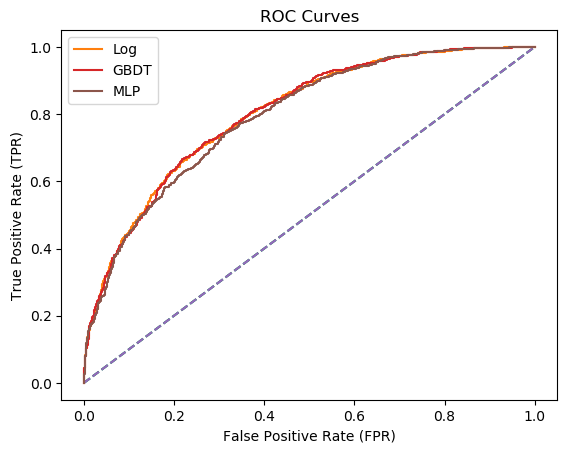

AUC Scores:
AUC for Logistic Regression: 0.8018088335700021
AUC for GBDT: 0.8022712192557595
AUC for MLP: 0.7930627722626287

Accuracy Scores:
Accuracy for Logistic Regression: 0.719910514541387
Accuracy for GBDT: 0.723489932885906
Accuracy for MLP: 0.5516778523489932


In [66]:
#LR ROC
fprlog, tprlog, thresholds = roc_curve(y_test, lr_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fprlog, tprlog, label='Log')

#GBDT ROC
fprlog, tprlog, thresholds = roc_curve(y_test, gbdt_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fprlog, tprlog, label='GBDT')

#MLP ROC
fprmlp, tprmlp, thresholds = roc_curve(y_test, mlp_pred)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fprmlp, tprmlp, label='MLP')

plt.title('ROC Curves')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

print("AUC Scores:")
print("AUC for Logistic Regression:", roc_auc_score(y_test, lr_pred))
print("AUC for GBDT:", roc_auc_score(y_test, gbdt_pred))
print("AUC for MLP:", roc_auc_score(y_test, mlp_pred))

print("\nAccuracy Scores:")
print("Accuracy for Logistic Regression:", accuracy_score(y_test, lr.predict(X_test)))
print("Accuracy for GBDT:", accuracy_score(y_test, gbdt.predict(X_test)))
print("Accuracy for MLP:", accuracy_score(y_test, mlp.predict(X_test)))

In [67]:
from sklearn.metrics import confusion_matrix

gbdt = GradientBoostingClassifier(n_estimators = 100, learning_rate = .1, max_depth = 3)
gbdt.fit(X_train, y_train)
gbdt_y_pred = gbdt.predict(X_test)
gbdt_cm = confusion_matrix(y_test, gbdt_y_pred)
print("Confusion Matrix for GBDT Classifier:\n", gbdt_cm)

Confusion Matrix for GBDT Classifier:
 [[837 311]
 [307 780]]


In [68]:
from sklearn.metrics import roc_auc_score

gbdt_y_pred_auc = gbdt.predict_proba(X_test)[:,1]
print("AUC for GBDT Classifier:", roc_auc_score(y_test, gbdt_y_pred_auc))

AUC for GBDT Classifier: 0.8022712192557595


Text(0.5,1,'Feature Importance for GBDT Classifier')

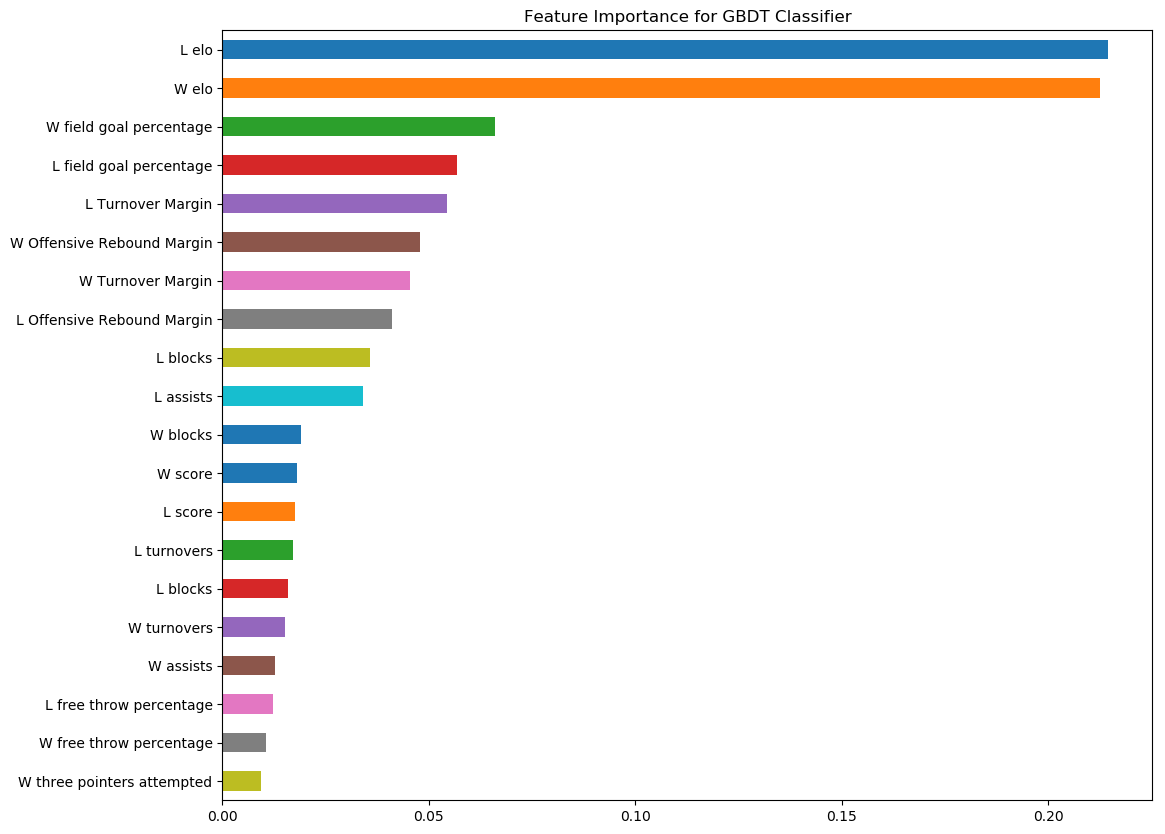

In [69]:
statdict = np.array(['W elo',
            'W tourney wins',
            'W score',
            'W blocks',
            'W field goal percentage',
            'W three pointers attempted',
            'W three point percentage',
            'W free throw percentage',
            'W offensive rebounds',
            'W Offensive Rebound Margin', 
            'W defensive rebounds',
            'W assists',
            'W turnovers',
            'W Turnover Margin',
            'W steals',
            'W blocks',
            'W personal fouls',
            'L elo',
            'L tourney wins',
            'L score',
            'L blocks',
            'L field goal percentage',
            'L three pointers attempted',
            'L three point percentage',
            'L free throw percentage',
            'L offensive rebounds',
            'L Offensive Rebound Margin', 
            'L defensive rebounds',
            'L assists',
            'L turnovers',
            'L Turnover Margin',
            'L steals',
            'L blocks',
            'L personal fouls',
           ],dtype='str')


plt.figure(figsize=(12,10))
(pd.Series(gbdt.feature_importances_,index=statdict).nlargest(20).plot(kind='barh'))
plt.gca().invert_yaxis()
plt.title("Feature Importance for GBDT Classifier")

## Predictions

In [72]:
#fit the model
model = linear_model.LogisticRegression(C=.01)
print("Check Neg Log Loss")
print(cross_validation.cross_val_score(model, numpy.array(X), numpy.array(y), cv=10, scoring='neg_log_loss', n_jobs=-1).mean())
_ = model.fit(X, y)

Check Neg Log Loss
-0.5295681596857763


In [73]:
#logistic regression
tourney_teams = []
for index, row in seeds.iterrows():
    if row['Season'] == prediction_year:
        tourney_teams.append(row['TeamID'])
tourney_teams.sort()
for team_1 in tourney_teams:
    for team_2 in tourney_teams:
        if team_1 < team_2:
            prediction = predict_winner(team_1, team_2, model, prediction_year, stat_fields)
            label = str(prediction_year) + '_' + str(team_1) + '_' + str(team_2)
            submission_data.append([label, prediction[0][0]])
            


In [74]:
print("Writing %d results." % len(submission_data))
submission_data2=pd.DataFrame(submission_data)
submission_data2.to_csv("submission1.csv", index=False)
def build_team_dict():
    team_ids = pd.read_csv('Teams.csv')
    team_id_map = {}
    for index, row in team_ids.iterrows():
        team_id_map[row['TeamID']] = row['TeamName']
    return team_id_map
team_id_map = build_team_dict()
readable = []
less_readable = []  # A version that's easy to look up.
for pred in submission_data:
    parts = pred[0].split('_')
    less_readable.append(
        [team_id_map[int(parts[1])], team_id_map[int(parts[2])], pred[1]])
    # Order them properly.
    if pred[1] > 0.5:
        winning = int(parts[1])
        losing = int(parts[2])
        proba = pred[1]
    else:
        winning = int(parts[2])
        losing = int(parts[1])
        proba = 1 - pred[1]
    readable.append(
        [
            '%s beats %s: %f' %
            (team_id_map[winning], team_id_map[losing], proba)
        ]
    )

Writing 2278 results.


In [75]:
Finalpredictions=pd.DataFrame(readable)
Finalpredictions.to_csv("FinalpredictionsLR.csv", index=False)

In [76]:
#GBDT 
tourney_teams = []
for index, row in seeds.iterrows():
    if row['Season'] == prediction_year:
        tourney_teams.append(row['TeamID'])
tourney_teams.sort()

gbdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
gbdt.fit(np.array(X), np.array(y))

for team_1 in tourney_teams:
    for team_2 in tourney_teams:
        if team_1 < team_2:
            prediction = predict_winner(team_1, team_2, gbdt, prediction_year, stat_fields)
            label = str(prediction_year) + '_' + str(team_1) + '_' + str(team_2)
            submission_data.append([label, prediction[0][0]])

In [77]:
print("Writing %d results." % len(submission_data))
submission_data2=pd.DataFrame(submission_data)
submission_data2.to_csv("submission1.csv", index=False)
def build_team_dict():
    team_ids = pd.read_csv('Teams.csv')
    team_id_map = {}
    for index, row in team_ids.iterrows():
        team_id_map[row['TeamID']] = row['TeamName']
    return team_id_map
team_id_map = build_team_dict()
readable = []
less_readable = []  # A version that's easy to look up.
for pred in submission_data:
    parts = pred[0].split('_')
    less_readable.append(
        [team_id_map[int(parts[1])], team_id_map[int(parts[2])], pred[1]])
    # Order them properly.
    if pred[1] > 0.5:
        winning = int(parts[1])
        losing = int(parts[2])
        proba = pred[1]
    else:
        winning = int(parts[2])
        losing = int(parts[1])
        proba = 1 - pred[1]
    readable.append(
        [
            '%s beats %s: %f' %
            (team_id_map[winning], team_id_map[losing], proba)
        ]
    )

Writing 4556 results.


In [78]:
Finalpredictions=pd.DataFrame(readable)
Finalpredictions.to_csv("FinalpredictionsGBDT.csv", index=False)

In [79]:
#get relative feature importances
def get_feature_importances(estimator, norm_order=1):
    """Retrieve or aggregate feature importances from estimator"""
    importances = getattr(estimator, "feature_importances_", None)

    if importances is None and hasattr(estimator, "coef_"):
        if estimator.coef_.ndim == 1:
            importances = np.abs(estimator.coef_)

        else:
            importances = np.linalg.norm(estimator.coef_, axis=0,
                                         ord=norm_order)

    elif importances is None:
        raise ValueError(
            "The underlying estimator %s has no `coef_` or "
            "`feature_importances_` attribute. Either pass a fitted estimator"
            " to SelectFromModel or call fit before calling transform."
            % estimator.__class__.__name__)

    return importances

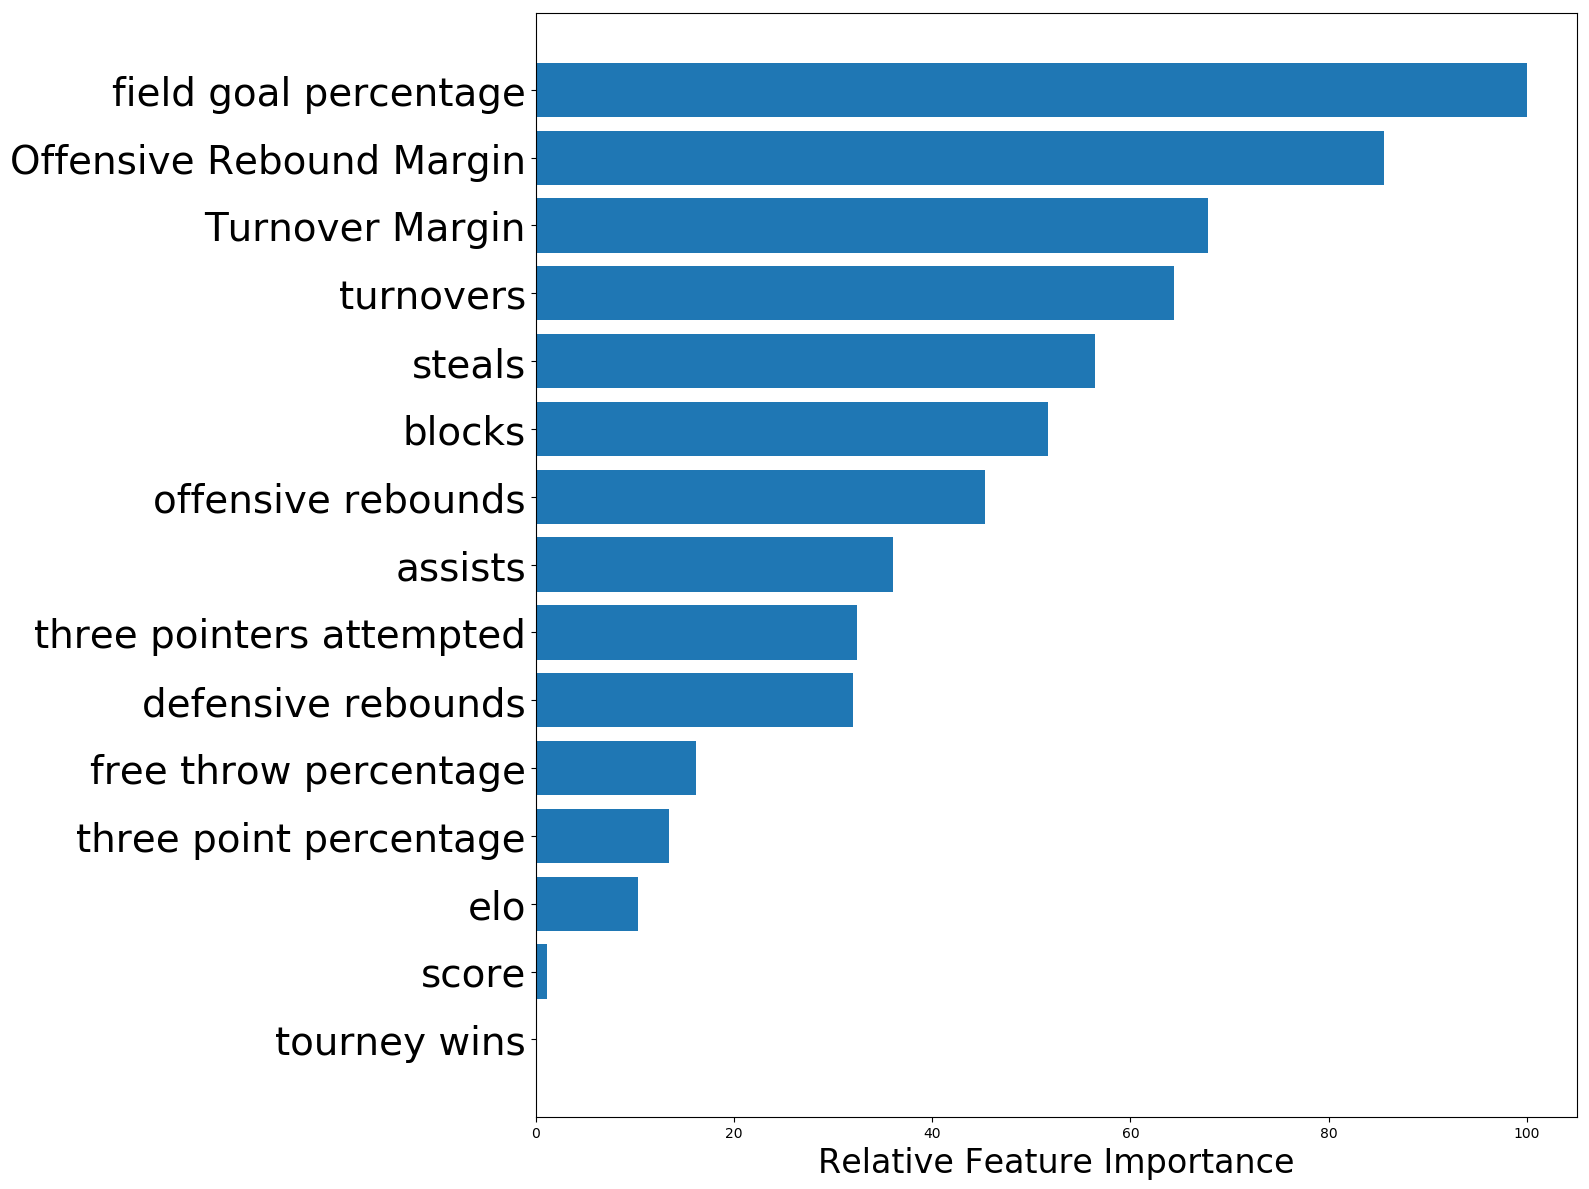

In [87]:
# Feature Importance for LR
import numpy as np
import matplotlib.pyplot as plt

importances = np.array(get_feature_importances(model))[17:34]
statdict = np.array(['elo',
            'tourney wins',
            'score',
            'blocks',
            'field goal percentage',
            'three pointers attempted',
            'three point percentage',
            'free throw percentage',
            'offensive rebounds',
            'Offensive Rebound Margin', 
            'defensive rebounds',
            'assists',
            'turnovers',
            'Turnover Margin',
            'steals',
            'blocks',
            'personal fouls',
           ],dtype='str')
    
feature_importance = abs(model.coef_[0][:15])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


featfig = plt.figure(figsize=(16,12))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(statdict[sorted_idx], fontsize=28)
featax.set_xlabel('Relative Feature Importance',fontsize=24)

plt.tight_layout()   
plt.show()


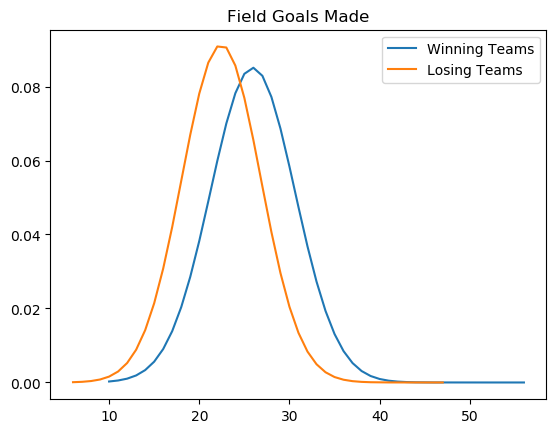

In [43]:
#WFGM vs. LFGM - field goals made

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

season_results = pd.read_csv('RegularSeasonDetailedResults.csv')
winner_fgm = season_results["WFGM"].values
loser_fgm = season_results["LFGM"].values

winner_sort = winner_fgm.sort()
loser_sort = loser_fgm.sort()

winner_mean = winner_fgm.mean()
loser_mean = loser_fgm.mean()

winner_std = winner_fgm.std()
loser_std = loser_fgm.std()

w_pdf = stats.norm.pdf(winner_fgm, winner_mean, winner_std)
l_pdf = stats.norm.pdf(loser_fgm, loser_mean, loser_std)
plt.plot(winner_fgm, w_pdf, label='Winning Teams')
plt.plot(loser_fgm, l_pdf, label = 'Losing Teams')
plt.legend()
plt.title('Field Goals Made')
plt.savefig('Field Goals Made.jpg')
plt.show()

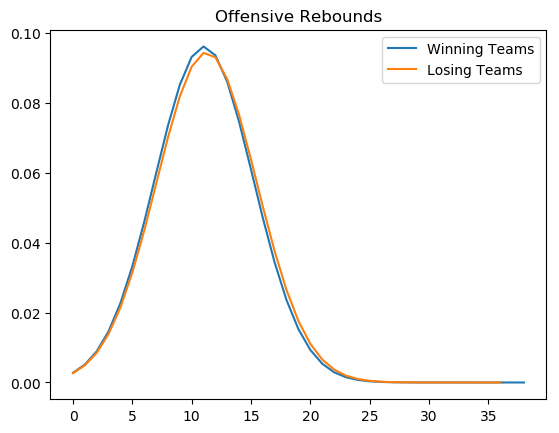

In [34]:
#WOR vs LOR - offensive rebounds
season_results = pd.read_csv('RegularSeasonDetailedResults.csv')
winner_or = season_results["WOR"].values
loser_or = season_results["LOR"].values

winner_sort = winner_or.sort()
loser_sort = loser_or.sort()

winner_mean = winner_or.mean()
loser_mean = loser_or.mean()

winner_std = winner_or.std()
loser_std = loser_or.std()

w_pdf = stats.norm.pdf(winner_or, winner_mean, winner_std)
l_pdf = stats.norm.pdf(loser_or, loser_mean, loser_std)
plt.plot(winner_or, w_pdf, label='Winning Teams')
plt.plot(loser_or, l_pdf, label='Losing Teams')
plt.legend()
plt.title('Offensive Rebounds')
plt.savefig('Offensive Rebounds.jpg')
plt.show()

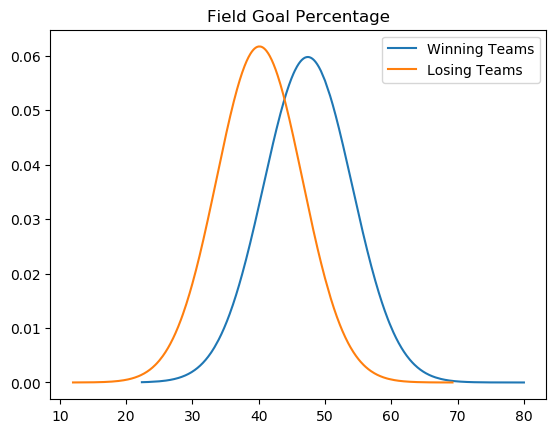

In [35]:
#field goal percentage
#'fgp': row['WFGM'] / row['WFGA'] * 100,
season_results = pd.read_csv('RegularSeasonDetailedResults.csv')
winner_made = season_results["WFGM"].values
winner_attempt = season_results["WFGA"].values
winner_percent = winner_made/winner_attempt * 100

loser_made = season_results["LFGM"].values
loser_attempt = season_results["LFGA"].values
loser_percent = loser_made/loser_attempt * 100

winner_sort = winner_percent.sort()
loser_sort = loser_percent.sort()

winner_mean = winner_percent.mean()
loser_mean = loser_percent.mean()

winner_std = winner_percent.std()
loser_std = loser_percent.std()

w_pdf = stats.norm.pdf(winner_percent, winner_mean, winner_std)
l_pdf = stats.norm.pdf(loser_percent, loser_mean, loser_std)
plt.plot(winner_percent, w_pdf, label='Winning Teams')
plt.plot(loser_percent, l_pdf, label='Losing Teams')
plt.legend()
plt.title('Field Goal Percentage')
plt.savefig('Field Goal Percentage.jpg')
plt.show()

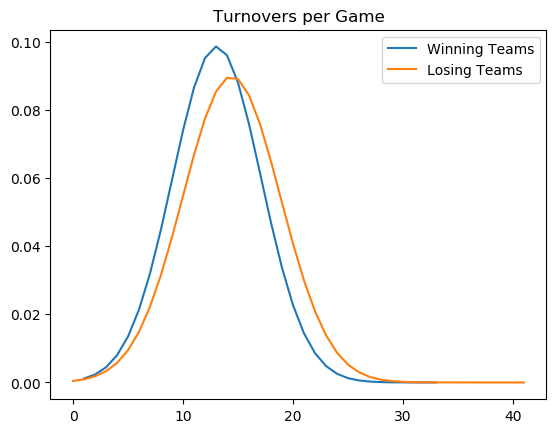

In [36]:
#Turnovers per Game
season_results = pd.read_csv('RegularSeasonDetailedResults.csv')
winner_to = season_results["WTO"].values
loser_to = season_results["LTO"].values

winner_sort = winner_to.sort()
loser_sort = loser_to.sort()

winner_mean = winner_to.mean()
loser_mean = loser_to.mean()

winner_std = winner_to.std()
loser_std = loser_to.std()

w_pdf = stats.norm.pdf(winner_to, winner_mean, winner_std)
l_pdf = stats.norm.pdf(loser_to, loser_mean, loser_std)
plt.plot(winner_to, w_pdf, label='Winning Teams')
plt.plot(loser_to, l_pdf, label='Losing Teams')
plt.legend()
plt.title('Turnovers per Game')
plt.savefig('Turnovers.jpg')
plt.show()

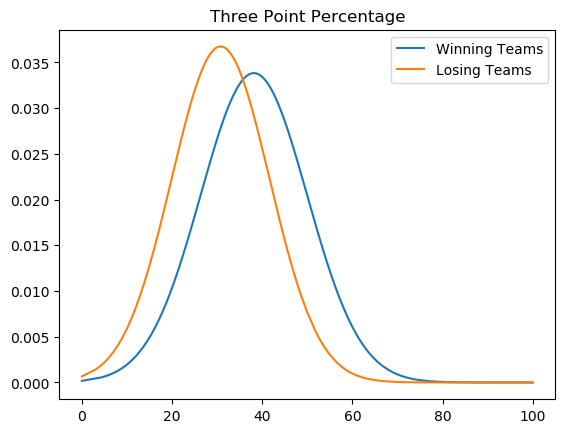

In [37]:
#Three point percentage
#'3pp': row['LFGM3'] / row['LFGA3'] * 100,
season_results = pd.read_csv('RegularSeasonDetailedResults.csv')
winner_made = season_results["WFGM3"].values
winner_attempt = season_results["WFGA3"].values
winner_percent = winner_made/winner_attempt * 100

loser_made = season_results["LFGM3"].values
loser_attempt = season_results["LFGA3"].values
loser_percent = loser_made/loser_attempt * 100

winner_sort = winner_percent.sort()
loser_sort = loser_percent.sort()

winner_mean = winner_percent.mean()
loser_mean = loser_percent.mean()

winner_std = winner_percent.std()
loser_std = loser_percent.std()

w_pdf = stats.norm.pdf(winner_percent, winner_mean, winner_std)
l_pdf = stats.norm.pdf(loser_percent, loser_mean, loser_std)
plt.plot(winner_percent, w_pdf, label='Winning Teams')
plt.plot(loser_percent, l_pdf, label='Losing Teams')
plt.legend()
plt.title('Three Point Percentage')
plt.savefig('Three Point Percentage.jpg')
plt.show()

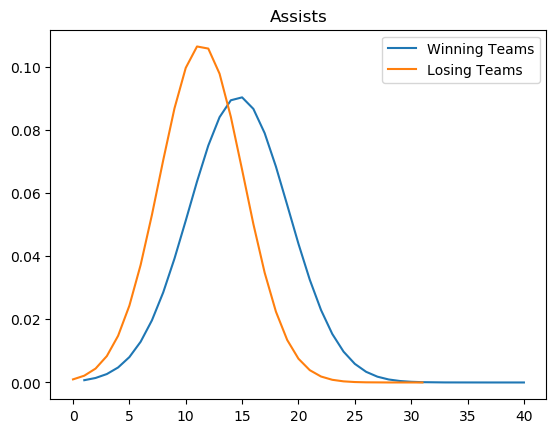

In [38]:
#assists
season_results = pd.read_csv('RegularSeasonDetailedResults.csv')
winner_ast = season_results["WAst"].values
loser_ast = season_results["LAst"].values

winner_sort = winner_ast.sort()
loser_sort = loser_ast.sort()

winner_mean = winner_ast.mean()
loser_mean = loser_ast.mean()

winner_std = winner_ast.std()
loser_std = loser_ast.std()

w_pdf = stats.norm.pdf(winner_ast, winner_mean, winner_std)
l_pdf = stats.norm.pdf(loser_ast, loser_mean, loser_std)
plt.plot(winner_ast, w_pdf, label='Winning Teams')
plt.plot(loser_ast, l_pdf, label='Losing Teams')
plt.legend()
plt.title('Assists')
plt.savefig('Assists.jpg')
plt.show()

In [18]:
df_seeds = pd.read_csv('NCAATourneySeeds1.csv')
df_tour = pd.read_csv('NCAATourneyDetailedResults.csv')
df_compact = pd.read_csv('NCAATourneyCompactResults1.csv')

In [19]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [20]:
df_seeds.head()

,Season,Seed,TeamID
0,2003,W01,1328
1,2003,W02,1448
2,2003,W03,1393
3,2003,W04,1257
4,2003,W05,1280


In [21]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

,Season,TeamID,seed_int
0,2003,1328,1
1,2003,1448,2
2,2003,1393,3
3,2003,1257,4
4,2003,1280,5


In [22]:
def getWTOs (row):
    teamTO = get_stat(row['Season'], row['WTeamID'], 'tomargin')
    return teamTO

def getLTOs (row):
    teamTO = get_stat(row['Season'], row['LTeamID'], 'tomargin')
    return teamTO

def getWORs (row):
    teamOR = get_stat(row['Season'], row['WTeamID'], 'ormargin')
    return teamOR

def getLORs (row):
    teamOR = get_stat(row['Season'], row['LTeamID'], 'ormargin')
    return teamOR

In [23]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat['TOMargin'] = df_concat.LTO - df_concat.WTO
df_concat['OffRebMargin'] = df_concat.WOR - df_concat.LOR
df_concat['WTeamSeasonTO'] = df_concat.apply (lambda row: getWTOs (row),axis=1)
df_concat['LTeamSeasonTO'] = df_concat.apply (lambda row: getLTOs (row),axis=1)
df_concat['WTeamSeasonOR'] = df_concat.apply (lambda row: getWORs (row),axis=1)
df_concat['LTeamSeasonOR'] = df_concat.apply (lambda row: getLORs (row),axis=1)
#df_concat['SeasonTOMargin'] = df_concat.LTeamSeasonTO - df_concat.WTeamSeasonTO
#df_concat['SeasonORMargin'] = df_concat.WTeamSeasonOR - df_concat.LTeamSeasonOR
df_concat.head(20)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LPF,WSeed,LSeed,SeedDiff,TOMargin,OffRebMargin,WTeamSeasonTO,LTeamSeasonTO,WTeamSeasonOR,LTeamSeasonOR
0,2003,134,1421,92,1411,84,N,1,32,69,...,22,16,16,0,3,-3,-3.888889,-1.111111,-1.444444,1.777778
1,2003,136,1112,80,1436,51,N,0,31,66,...,15,1,16,-15,1,3,4.666667,-1.777778,3.000000,1.666667
2,2003,136,1113,84,1272,71,N,0,31,59,...,18,10,7,3,3,-10,1.777778,1.777778,3.777778,3.000000
3,2003,136,1141,79,1166,73,N,0,29,53,...,21,11,6,5,3,-3,-2.777778,4.555556,1.000000,0.777778
4,2003,136,1143,76,1301,74,N,1,27,64,...,19,8,9,-1,1,8,1.444444,5.555556,1.888889,0.000000
5,2003,136,1163,58,1140,53,N,0,17,52,...,22,5,12,-7,-3,-3,3.000000,-0.222222,0.888889,-2.666667
6,2003,136,1181,67,1161,57,N,0,19,54,...,19,3,14,-11,3,2,6.666667,-1.222222,2.000000,-0.111111
7,2003,136,1211,74,1153,69,N,0,20,47,...,24,9,8,1,-2,-5,-0.444444,4.555556,-1.111111,3.111111
8,2003,136,1228,65,1443,60,N,0,24,56,...,16,4,13,-9,0,-2,3.222222,0.444444,2.444444,-0.444444
9,2003,136,1242,64,1429,61,N,0,28,51,...,15,2,15,-13,2,-6,1.000000,0.666667,4.333333,5.222222


In [24]:
upsetgames = df_concat[df_concat.SeedDiff >= 4]
nongames = df_concat[df_concat.SeedDiff < 4]

In [25]:
upsetgames.head(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LPF,WSeed,LSeed,SeedDiff,TOMargin,OffRebMargin,WTeamSeasonTO,LTeamSeasonTO,WTeamSeasonOR,LTeamSeasonOR
3,2003,136,1141,79,1166,73,N,0,29,53,...,21,11,6,5,3,-3,-2.777778,4.555556,1.000000,0.777778
15,2003,136,1409,84,1173,71,N,0,33,57,...,19,13,4,9,-1,-4,0.444444,-1.666667,-0.777778,4.555556
18,2003,137,1139,47,1280,46,N,0,18,47,...,13,12,5,7,2,-1,1.888889,2.444444,-4.222222,6.333333
41,2003,139,1120,68,1448,62,N,0,24,56,...,23,10,2,8,4,0,-3.666667,0.111111,-2.000000,5.777778
42,2003,139,1139,79,1257,71,N,0,27,52,...,21,12,4,8,2,2,1.888889,2.444444,-4.222222,1.222222
45,2003,139,1277,68,1196,46,N,0,25,45,...,20,7,2,5,4,1,-1.444444,1.444444,1.888889,-0.777778
70,2004,136,1264,75,1196,60,N,0,26,60,...,18,12,5,7,4,9,4.777778,-3.444444,2.555556,-0.333333
91,2004,137,1334,66,1344,58,N,0,24,50,...,18,12,5,7,3,-8,-1.111111,1.888889,-3.000000,1.555556
97,2004,138,1104,70,1390,67,N,0,16,43,...,31,8,1,7,4,-17,1.888889,-0.111111,-0.222222,4.666667
100,2004,138,1305,91,1211,72,N,0,30,64,...,23,10,2,8,2,-5,0.777778,-0.888889,1.222222,-0.555556


In [26]:
nongames.head(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LPF,WSeed,LSeed,SeedDiff,TOMargin,OffRebMargin,WTeamSeasonTO,LTeamSeasonTO,WTeamSeasonOR,LTeamSeasonOR
0,2003,134,1421,92,1411,84,N,1,32,69,...,22,16,16,0,3,-3,-3.888889,-1.111111,-1.444444,1.777778
1,2003,136,1112,80,1436,51,N,0,31,66,...,15,1,16,-15,1,3,4.666667,-1.777778,3.000000,1.666667
2,2003,136,1113,84,1272,71,N,0,31,59,...,18,10,7,3,3,-10,1.777778,1.777778,3.777778,3.000000
4,2003,136,1143,76,1301,74,N,1,27,64,...,19,8,9,-1,1,8,1.444444,5.555556,1.888889,0.000000
5,2003,136,1163,58,1140,53,N,0,17,52,...,22,5,12,-7,-3,-3,3.000000,-0.222222,0.888889,-2.666667
6,2003,136,1181,67,1161,57,N,0,19,54,...,19,3,14,-11,3,2,6.666667,-1.222222,2.000000,-0.111111
7,2003,136,1211,74,1153,69,N,0,20,47,...,24,9,8,1,-2,-5,-0.444444,4.555556,-1.111111,3.111111
8,2003,136,1228,65,1443,60,N,0,24,56,...,16,4,13,-9,0,-2,3.222222,0.444444,2.444444,-0.444444
9,2003,136,1242,64,1429,61,N,0,28,51,...,15,2,15,-13,2,-6,1.000000,0.666667,4.333333,5.222222
10,2003,136,1266,72,1221,68,N,0,22,51,...,20,3,14,-11,-1,-3,0.888889,2.555556,0.000000,3.222222


In [27]:
upsetTOWin = upsetgames['WTeamSeasonTO'].mean()
#print(upsetTOWin)

upsetTOLoss = upsetgames['LTeamSeasonTO'].mean()
#print(upsetTOLoss)

upsetORWin = upsetgames['WTeamSeasonOR'].mean()
#print(upsetORWin)

upsetORLoss = upsetgames['LTeamSeasonOR'].mean()
#print(upsetORLoss)

print(upsetTOWin + upsetORWin)
print(upsetTOLoss + upsetORLoss)

2.628548256285481
3.343065693430657


In [28]:
nonTOWin = nongames['WTeamSeasonTO'].mean()
#print(upsetTOWin)

nonTOLoss = nongames['LTeamSeasonTO'].mean()
#print(upsetTOLoss)

nonORWin = nongames['WTeamSeasonOR'].mean()
#print(upsetORWin)

nonORLoss = nongames['LTeamSeasonOR'].mean()
#print(upsetORLoss)

print(nonTOWin + nonORWin)
print(nonTOLoss + nonORLoss)

3.719589257503944
1.9611637704054776


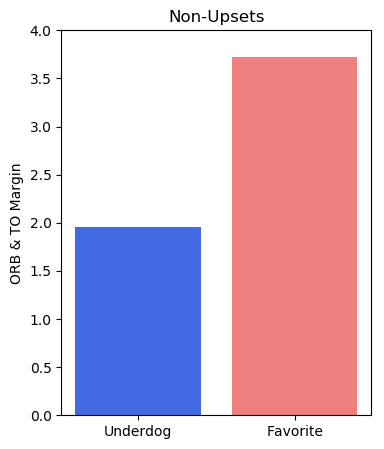

In [51]:
#predicting upsets
upset_vals = [1.96, 3.72]
upset_vals2 = [3.34, 2.63]
names = ['Underdog', 'Favorite']
names_index = np.arange(len(names))
plt.figure(figsize=(4,5))
plt.bar(names, upset_vals, color= ['royalblue', 'lightcoral'])
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,4))
plt.ylabel('ORB & TO Margin')
plt.title('Non-Upsets')
plt.savefig('Upsets1.jpg')
plt.show()

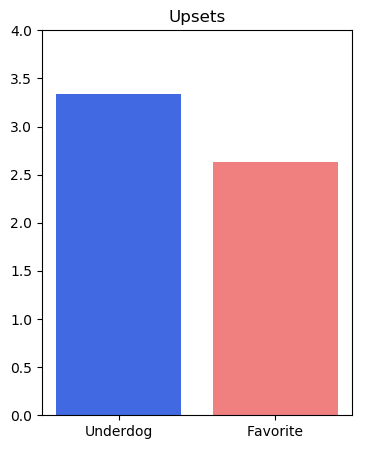

In [53]:
names = ['Underdog', 'Favorite']
names_index = np.arange(len(names))
plt.figure(figsize=(4,5))
plt.bar(names, upset_vals2, color= ['royalblue', 'lightcoral'])
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,4))
plt.title('Upsets')
plt.savefig('Upsets2.jpg')
plt.show()